In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

2023-06-16 01:51:04.771508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 01:51:05.318991: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


2023-06-16 01:51:05.906328: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-16 01:51:05.906355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: isidro-PC
2023-06-16 01:51:05.906361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: isidro-PC
2023-06-16 01:51:05.906426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.105.17
2023-06-16 01:51:05.906444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.105.17
2023-06-16 01:51:05.906449: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.105.17


In [3]:
data_folder = 'Data_SNIa_LSST/'
dfp = pd.read_csv(data_folder+'hubble_diagram_Pr.txt', skiprows=4, sep=' ')
dfs = pd.read_csv(data_folder+'hubble_diagram_Sr.txt', skiprows=4, sep=' ')
Np = len(dfp.values)
Ns= len(dfs.values)
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS
0,0.04131,0.04131,36.31666,0.00969,0.00674
1,0.06876,0.06876,37.44798,0.00541,0.00627
2,0.13121,0.13121,38.94492,0.01969,0.00868
3,0.18499,0.18499,39.75545,0.01338,0.00658
4,0.24503,0.24503,40.42469,0.01068,0.00590


In [4]:
dfp['zCMB'].values

array([0.04131, 0.06876, 0.13121, 0.18499, 0.24503, 0.31077, 0.38392,
       0.46752, 0.55669, 0.66538, 0.78147, 0.92328, 1.08255, 1.24447])

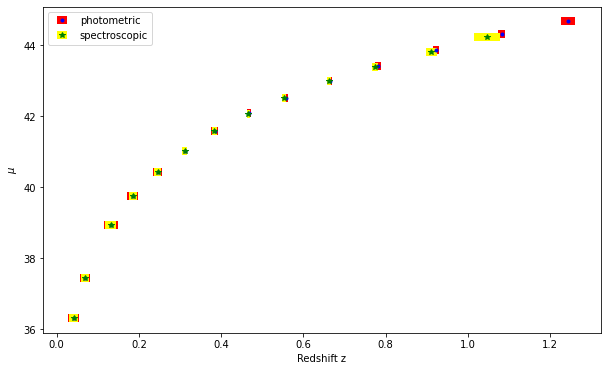

In [5]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(dfp['zCMB'].values, dfp['MU'].values, xerr=dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values, fmt='.', color='b', elinewidth=8, ecolor='red', label='photometric')
plt.errorbar(dfs['zCMB'].values, dfs['MU'].values, xerr=dfs['MUERR_SYS'].values+dfs['MUERR_SYS'].values, fmt='*', color='g', elinewidth=8, ecolor='yellow', label='spectroscopic')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [6]:
dfp['errors'] = dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS,errors
0,0.04131,0.04131,36.31666,0.00969,0.00674,0.01348
1,0.06876,0.06876,37.44798,0.00541,0.00627,0.01254
2,0.13121,0.13121,38.94492,0.01969,0.00868,0.01736
3,0.18499,0.18499,39.75545,0.01338,0.00658,0.01316
4,0.24503,0.24503,40.42469,0.01068,0.00590,0.01180


In [7]:
dfp = dfp[['zCMB', 'MU', 'errors']]

In [8]:
len(dfp)

14

In [9]:
dfp.head()

,zCMB,MU,errors
0,0.04131,36.31666,0.01348
1,0.06876,37.44798,0.01254
2,0.13121,38.94492,0.01736
3,0.18499,39.75545,0.01316
4,0.24503,40.42469,0.01180


In [10]:
noise1x = 0.005*np.random.rand(len(dfp))
noise1y = np.zeros((14, 2))
noise1y[:,0] = noise1x * 2
noise1y[:,1] = noise1x * 0.1

noise2x = 0.005*np.random.rand(len(dfp))
noise2y = np.zeros((14, 2))
noise2y[:,0] = noise2x * 2
noise2y[:,1] = noise2x * 0.1


In [11]:
np.shape(noise1y)

(14, 2)

In [12]:
z_or = dfp.values[:,0]
y_or = dfp.values[:,1:]

z = np.append(z_or, z_or+noise1x)
z = np.append(z, z_or+noise2x)

y = np.append(y_or, y_or+noise1y, axis=0)
y = np.append(y, y_or+noise2y, axis=0)


randomize = np.random.permutation(len(z))
z = z[randomize]
y = y[randomize]

In [13]:
np.shape(y), np.shape(z)

((42, 2), (42,))

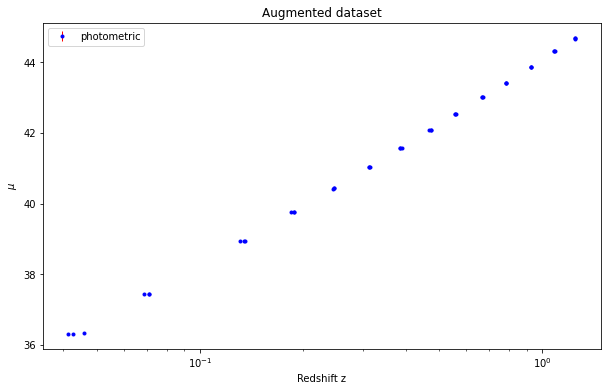

In [14]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(z, y[:,0], yerr=y[:,1], fmt='.', color='b', elinewidth=1, ecolor='red', label='photometric')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.title("Augmented dataset")
plt.xscale('log')
plt.legend()

In [15]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [16]:
split = 0.9
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [17]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [18]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
yy_train = np.append(yy_train, np.array([y[0], y[-1]]))
zz_train = np.append(zz_train, np.array([zz[0], zz[-1]]))
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((35,), (37,), (9, 1), (9, 1))

In [19]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 8
# optimizer = Adam(lr=.005)
optimizer = Adam(learning_rate=0.0005)


# Compile Keras model
model = model_regression_dropout(num_hidden=[100,100,100])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               200       
                                                                 
 MCDropout_1 (MCDropout)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 MCDropout_2 (MCDropout)     (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 MCDropout_3 (MCDropout)     (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 2

In [20]:
model.compile(loss='mse', optimizer=optimizer) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=400)
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=2000, verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/2000
5/5 [==============================] - 1s 28ms/step - loss: 859.9885 - val_loss: 887.9873
Epoch 2/2000
5/5 [==============================] - 0s 5ms/step - loss: 855.2935 - val_loss: 880.8646
Epoch 3/2000
5/5 [==============================] - 0s 5ms/step - loss: 852.5385 - val_loss: 877.3824
Epoch 4/2000
5/5 [==============================] - 0s 5ms/step - loss: 848.4312 - val_loss: 877.5736
Epoch 5/2000
5/5 [==============================] - 0s 5ms/step - loss: 843.1733 - val_loss: 873.9592
Epoch 6/2000
5/5 [==============================] - 0s 5ms/step - loss: 840.8135 - val_loss: 869.2435
Epoch 7/2000
5/5 [==============================] - 0s 5ms/step - loss: 835.2468 - val_loss: 862.7466
Epoch 8/2000
5/5 [==============================] - 0s 5ms/step - loss: 832.1954 - val_loss: 858.6896
Epoch 9/2000
5/5 [==============================] - 0s 5ms/step - loss: 827.3425 - val_loss: 860.8346
Epoch 10/2000
5/5 [==============================] - 0s 5ms/step - loss: 818.4102

5/5 [==============================] - 0s 5ms/step - loss: 55.4310 - val_loss: 81.7077
Epoch 82/2000
5/5 [==============================] - 0s 5ms/step - loss: 53.7619 - val_loss: 15.9516
Epoch 83/2000
5/5 [==============================] - 0s 5ms/step - loss: 65.0913 - val_loss: 121.5546
Epoch 84/2000
5/5 [==============================] - 0s 5ms/step - loss: 68.4911 - val_loss: 58.7770
Epoch 85/2000
5/5 [==============================] - 0s 5ms/step - loss: 62.4029 - val_loss: 91.2260
Epoch 86/2000
5/5 [==============================] - 0s 5ms/step - loss: 52.1294 - val_loss: 18.6260
Epoch 87/2000
5/5 [==============================] - 0s 5ms/step - loss: 87.2033 - val_loss: 25.8186
Epoch 88/2000
5/5 [==============================] - 0s 5ms/step - loss: 67.4906 - val_loss: 117.1629
Epoch 89/2000
5/5 [==============================] - 0s 4ms/step - loss: 63.2933 - val_loss: 37.5347
Epoch 90/2000
5/5 [==============================] - 0s 5ms/step - loss: 57.2927 - val_loss: 62.2894
Ep

5/5 [==============================] - 0s 5ms/step - loss: 50.9416 - val_loss: 107.9971
Epoch 162/2000
5/5 [==============================] - 0s 5ms/step - loss: 33.2299 - val_loss: 86.1658
Epoch 163/2000
5/5 [==============================] - 0s 5ms/step - loss: 37.9016 - val_loss: 38.0285
Epoch 164/2000
5/5 [==============================] - 0s 5ms/step - loss: 46.4696 - val_loss: 22.2747
Epoch 165/2000
5/5 [==============================] - 0s 5ms/step - loss: 42.1054 - val_loss: 46.0058
Epoch 166/2000
5/5 [==============================] - 0s 5ms/step - loss: 56.2420 - val_loss: 44.7727
Epoch 167/2000
5/5 [==============================] - 0s 5ms/step - loss: 27.3719 - val_loss: 37.3816
Epoch 168/2000
5/5 [==============================] - 0s 4ms/step - loss: 60.1599 - val_loss: 50.6192
Epoch 169/2000
5/5 [==============================] - 0s 5ms/step - loss: 32.6857 - val_loss: 33.4767
Epoch 170/2000
5/5 [==============================] - 0s 5ms/step - loss: 42.9283 - val_loss: 10

5/5 [==============================] - 0s 5ms/step - loss: 36.9342 - val_loss: 7.5893
Epoch 242/2000
5/5 [==============================] - 0s 5ms/step - loss: 40.7045 - val_loss: 51.3211
Epoch 243/2000
5/5 [==============================] - 0s 5ms/step - loss: 21.9088 - val_loss: 26.3812
Epoch 244/2000
5/5 [==============================] - 0s 5ms/step - loss: 38.6222 - val_loss: 19.2690
Epoch 245/2000
5/5 [==============================] - 0s 5ms/step - loss: 29.6491 - val_loss: 35.3863
Epoch 246/2000
5/5 [==============================] - 0s 5ms/step - loss: 32.1679 - val_loss: 14.1828
Epoch 247/2000
5/5 [==============================] - 0s 5ms/step - loss: 23.5383 - val_loss: 47.9917
Epoch 248/2000
5/5 [==============================] - 0s 5ms/step - loss: 32.5288 - val_loss: 26.5419
Epoch 249/2000
5/5 [==============================] - 0s 4ms/step - loss: 39.6912 - val_loss: 52.8333
Epoch 250/2000
5/5 [==============================] - 0s 5ms/step - loss: 48.3811 - val_loss: 19.3

5/5 [==============================] - 0s 5ms/step - loss: 24.9529 - val_loss: 65.4776
Epoch 322/2000
5/5 [==============================] - 0s 5ms/step - loss: 37.8446 - val_loss: 20.2106
Epoch 323/2000
5/5 [==============================] - 0s 5ms/step - loss: 27.4760 - val_loss: 42.8329
Epoch 324/2000
5/5 [==============================] - 0s 5ms/step - loss: 45.6538 - val_loss: 13.8112
Epoch 325/2000
5/5 [==============================] - 0s 5ms/step - loss: 36.0803 - val_loss: 30.8483
Epoch 326/2000
5/5 [==============================] - 0s 5ms/step - loss: 25.3862 - val_loss: 24.2238
Epoch 327/2000
5/5 [==============================] - 0s 5ms/step - loss: 21.1487 - val_loss: 19.2844
Epoch 328/2000
5/5 [==============================] - 0s 5ms/step - loss: 29.5707 - val_loss: 70.0620
Epoch 329/2000
5/5 [==============================] - 0s 5ms/step - loss: 24.5425 - val_loss: 30.2651
Epoch 330/2000
5/5 [==============================] - 0s 5ms/step - loss: 27.7492 - val_loss: 13.

5/5 [==============================] - 0s 5ms/step - loss: 58.9642 - val_loss: 17.8712
Epoch 402/2000
5/5 [==============================] - 0s 5ms/step - loss: 29.1774 - val_loss: 33.2780
Epoch 403/2000
5/5 [==============================] - 0s 5ms/step - loss: 28.9317 - val_loss: 28.9915
Epoch 404/2000
5/5 [==============================] - 0s 5ms/step - loss: 21.9068 - val_loss: 13.1794
Epoch 405/2000
5/5 [==============================] - 0s 5ms/step - loss: 26.7012 - val_loss: 24.7301
Epoch 406/2000
5/5 [==============================] - 0s 5ms/step - loss: 31.3647 - val_loss: 11.9070
Epoch 407/2000
5/5 [==============================] - 0s 5ms/step - loss: 23.9834 - val_loss: 51.5135
Epoch 408/2000
5/5 [==============================] - 0s 5ms/step - loss: 40.0999 - val_loss: 16.0240
Epoch 409/2000
5/5 [==============================] - 0s 5ms/step - loss: 35.9046 - val_loss: 14.2792
Epoch 410/2000
5/5 [==============================] - 0s 5ms/step - loss: 26.6824 - val_loss: 47.

5/5 [==============================] - 0s 4ms/step - loss: 33.3400 - val_loss: 6.4919
Epoch 482/2000
5/5 [==============================] - 0s 5ms/step - loss: 26.2913 - val_loss: 80.2452
Epoch 483/2000
5/5 [==============================] - 0s 5ms/step - loss: 30.8083 - val_loss: 45.1380
Epoch 484/2000
5/5 [==============================] - 0s 5ms/step - loss: 39.7172 - val_loss: 25.5160
Epoch 485/2000
5/5 [==============================] - 0s 4ms/step - loss: 18.8778 - val_loss: 57.9208
Epoch 486/2000
5/5 [==============================] - 0s 4ms/step - loss: 32.2915 - val_loss: 24.1046
Epoch 487/2000
5/5 [==============================] - 0s 5ms/step - loss: 35.2422 - val_loss: 65.1815
Epoch 488/2000
5/5 [==============================] - 0s 4ms/step - loss: 38.1836 - val_loss: 11.0476
Epoch 489/2000
5/5 [==============================] - 0s 6ms/step - loss: 22.7609 - val_loss: 22.6538
Epoch 490/2000
5/5 [==============================] - 0s 5ms/step - loss: 31.7272 - val_loss: 33.1

5/5 [==============================] - 0s 5ms/step - loss: 29.8369 - val_loss: 26.5933
Epoch 562/2000
5/5 [==============================] - 0s 5ms/step - loss: 32.6622 - val_loss: 8.2583
Epoch 563/2000
5/5 [==============================] - 0s 5ms/step - loss: 26.5306 - val_loss: 16.0994
Epoch 564/2000
5/5 [==============================] - 0s 4ms/step - loss: 27.6478 - val_loss: 22.8036
Epoch 565/2000
5/5 [==============================] - 0s 5ms/step - loss: 21.5683 - val_loss: 50.1337
Epoch 566/2000
5/5 [==============================] - 0s 5ms/step - loss: 43.8098 - val_loss: 15.2438
Epoch 567/2000
5/5 [==============================] - 0s 5ms/step - loss: 33.6012 - val_loss: 46.5713
Epoch 568/2000
5/5 [==============================] - 0s 5ms/step - loss: 18.2731 - val_loss: 145.0954
Epoch 569/2000
5/5 [==============================] - 0s 5ms/step - loss: 29.7874 - val_loss: 16.9910
Epoch 570/2000
5/5 [==============================] - 0s 5ms/step - loss: 40.0800 - val_loss: 51.

5/5 [==============================] - 0s 5ms/step - loss: 27.3172 - val_loss: 50.9398
Epoch 642/2000
5/5 [==============================] - 0s 5ms/step - loss: 22.8435 - val_loss: 22.2529
Epoch 643/2000
5/5 [==============================] - 0s 5ms/step - loss: 22.1468 - val_loss: 9.5394
Epoch 644/2000
5/5 [==============================] - 0s 4ms/step - loss: 20.4031 - val_loss: 18.8146
Epoch 645/2000
5/5 [==============================] - 0s 5ms/step - loss: 20.0849 - val_loss: 49.0146
Epoch 646/2000
5/5 [==============================] - 0s 5ms/step - loss: 22.3822 - val_loss: 28.0455
Epoch 647/2000
5/5 [==============================] - 0s 5ms/step - loss: 42.1017 - val_loss: 36.9696
Epoch 648/2000
5/5 [==============================] - 0s 4ms/step - loss: 27.5160 - val_loss: 22.1340
Epoch 649/2000
5/5 [==============================] - 0s 5ms/step - loss: 29.6726 - val_loss: 51.4586
Epoch 650/2000
5/5 [==============================] - 0s 5ms/step - loss: 38.7400 - val_loss: 84.6

5/5 [==============================] - 0s 5ms/step - loss: 26.3204 - val_loss: 20.1209
Epoch 722/2000
5/5 [==============================] - 0s 5ms/step - loss: 21.2016 - val_loss: 26.9650
Epoch 723/2000
5/5 [==============================] - 0s 5ms/step - loss: 32.0347 - val_loss: 40.6067
Epoch 724/2000
5/5 [==============================] - 0s 5ms/step - loss: 24.0854 - val_loss: 18.4953
Epoch 725/2000
5/5 [==============================] - 0s 5ms/step - loss: 25.1253 - val_loss: 40.5497
Epoch 726/2000
5/5 [==============================] - 0s 5ms/step - loss: 28.8372 - val_loss: 47.0826
Epoch 727/2000
5/5 [==============================] - 0s 5ms/step - loss: 27.2709 - val_loss: 16.9244
Epoch 728/2000
5/5 [==============================] - 0s 5ms/step - loss: 24.3559 - val_loss: 5.9590
Epoch 729/2000
5/5 [==============================] - 0s 4ms/step - loss: 21.9839 - val_loss: 19.7874
Epoch 730/2000
5/5 [==============================] - 0s 5ms/step - loss: 29.6743 - val_loss: 12.5

5/5 [==============================] - 0s 5ms/step - loss: 17.8384 - val_loss: 21.0045
Epoch 802/2000
5/5 [==============================] - 0s 5ms/step - loss: 30.5581 - val_loss: 23.9873
Epoch 803/2000
5/5 [==============================] - 0s 5ms/step - loss: 23.2772 - val_loss: 5.9453
Epoch 804/2000
5/5 [==============================] - 0s 5ms/step - loss: 41.5214 - val_loss: 8.9652
Epoch 805/2000
5/5 [==============================] - 0s 5ms/step - loss: 24.0121 - val_loss: 14.7645
Epoch 806/2000
5/5 [==============================] - 0s 5ms/step - loss: 22.7512 - val_loss: 66.7394
Epoch 807/2000
5/5 [==============================] - 0s 5ms/step - loss: 12.5648 - val_loss: 53.4134
Epoch 808/2000
5/5 [==============================] - 0s 5ms/step - loss: 26.2753 - val_loss: 12.7761
Epoch 809/2000
5/5 [==============================] - 0s 5ms/step - loss: 27.4014 - val_loss: 32.0073
Epoch 810/2000
5/5 [==============================] - 0s 5ms/step - loss: 28.5273 - val_loss: 52.94

5/5 [==============================] - 0s 5ms/step - loss: 37.1145 - val_loss: 11.7349
Epoch 882/2000
5/5 [==============================] - 0s 5ms/step - loss: 23.5913 - val_loss: 21.6333
Epoch 883/2000
5/5 [==============================] - 0s 5ms/step - loss: 22.1881 - val_loss: 29.7269
Epoch 884/2000
5/5 [==============================] - 0s 6ms/step - loss: 24.5307 - val_loss: 26.2820
Epoch 885/2000
5/5 [==============================] - 0s 5ms/step - loss: 13.5886 - val_loss: 15.1226
Epoch 886/2000
5/5 [==============================] - 0s 5ms/step - loss: 29.9253 - val_loss: 5.6544
Epoch 887/2000
5/5 [==============================] - 0s 5ms/step - loss: 16.8502 - val_loss: 26.6307
Epoch 888/2000
5/5 [==============================] - 0s 5ms/step - loss: 19.5080 - val_loss: 10.4968
Epoch 889/2000
5/5 [==============================] - 0s 5ms/step - loss: 31.4675 - val_loss: 22.3786
Epoch 890/2000
5/5 [==============================] - 0s 5ms/step - loss: 22.4061 - val_loss: 27.1

5/5 [==============================] - 0s 5ms/step - loss: 19.6053 - val_loss: 12.5190
Epoch 962/2000
5/5 [==============================] - 0s 5ms/step - loss: 23.7337 - val_loss: 33.5319
Epoch 963/2000
5/5 [==============================] - 0s 5ms/step - loss: 24.6364 - val_loss: 18.9238
Epoch 964/2000
5/5 [==============================] - 0s 5ms/step - loss: 21.8716 - val_loss: 15.2691
Epoch 965/2000
5/5 [==============================] - 0s 5ms/step - loss: 28.5777 - val_loss: 34.3196
Epoch 966/2000
5/5 [==============================] - 0s 4ms/step - loss: 29.8686 - val_loss: 28.3870
Epoch 967/2000
5/5 [==============================] - 0s 5ms/step - loss: 20.0622 - val_loss: 2.9298
Epoch 968/2000
5/5 [==============================] - 0s 5ms/step - loss: 26.4876 - val_loss: 19.3598
Epoch 969/2000
5/5 [==============================] - 0s 5ms/step - loss: 19.2484 - val_loss: 14.9573
Epoch 970/2000
5/5 [==============================] - 0s 5ms/step - loss: 25.9909 - val_loss: 17.7

5/5 [==============================] - 0s 4ms/step - loss: 19.4638 - val_loss: 34.7404
Epoch 1042/2000
5/5 [==============================] - 0s 5ms/step - loss: 25.0204 - val_loss: 20.6860
Epoch 1043/2000
5/5 [==============================] - 0s 5ms/step - loss: 19.4938 - val_loss: 13.2841
Epoch 1044/2000
5/5 [==============================] - 0s 5ms/step - loss: 23.3114 - val_loss: 17.1487
Epoch 1045/2000
5/5 [==============================] - 0s 5ms/step - loss: 15.6112 - val_loss: 28.1745
Epoch 1046/2000
5/5 [==============================] - 0s 5ms/step - loss: 16.5961 - val_loss: 7.5387
Epoch 1047/2000
5/5 [==============================] - 0s 5ms/step - loss: 28.6112 - val_loss: 64.0643
Epoch 1048/2000
5/5 [==============================] - 0s 5ms/step - loss: 22.7920 - val_loss: 22.0229
Epoch 1049/2000
5/5 [==============================] - 0s 5ms/step - loss: 26.4954 - val_loss: 24.8593
Epoch 1050/2000
5/5 [==============================] - 0s 5ms/step - loss: 30.3048 - val_l

Epoch 1121/2000
5/5 [==============================] - 0s 5ms/step - loss: 18.8799 - val_loss: 37.5860
Epoch 1122/2000
5/5 [==============================] - 0s 6ms/step - loss: 26.4983 - val_loss: 5.4600
Epoch 1123/2000
5/5 [==============================] - 0s 5ms/step - loss: 20.7125 - val_loss: 2.8481
Epoch 1124/2000
5/5 [==============================] - 0s 5ms/step - loss: 22.7288 - val_loss: 15.5482
Epoch 1125/2000
5/5 [==============================] - 0s 4ms/step - loss: 18.9253 - val_loss: 11.0274
Epoch 1126/2000
5/5 [==============================] - 0s 5ms/step - loss: 18.9796 - val_loss: 14.9966
Epoch 1127/2000
5/5 [==============================] - 0s 5ms/step - loss: 22.3772 - val_loss: 35.5751
Epoch 1128/2000
5/5 [==============================] - 0s 5ms/step - loss: 12.6450 - val_loss: 18.9025
Epoch 1129/2000
5/5 [==============================] - 0s 5ms/step - loss: 17.7140 - val_loss: 10.5856
Epoch 1130/2000
5/5 [==============================] - 0s 5ms/step - loss: 

5/5 [==============================] - 0s 5ms/step - loss: 9.9520 - val_loss: 14.9069
Epoch 1201/2000
5/5 [==============================] - 0s 5ms/step - loss: 30.1136 - val_loss: 47.8900
Epoch 1202/2000
5/5 [==============================] - 0s 5ms/step - loss: 21.7044 - val_loss: 15.3951
Epoch 1203/2000
5/5 [==============================] - 0s 5ms/step - loss: 16.6263 - val_loss: 12.9165
Epoch 1204/2000
5/5 [==============================] - 0s 5ms/step - loss: 32.1769 - val_loss: 39.3742
Epoch 1205/2000
5/5 [==============================] - 0s 5ms/step - loss: 29.2519 - val_loss: 17.3534
Epoch 1206/2000
5/5 [==============================] - 0s 5ms/step - loss: 21.7787 - val_loss: 8.7731
Epoch 1207/2000
5/5 [==============================] - 0s 5ms/step - loss: 23.0433 - val_loss: 31.8068
Epoch 1208/2000
5/5 [==============================] - 0s 4ms/step - loss: 29.7437 - val_loss: 12.6242
Epoch 1209/2000
5/5 [==============================] - 0s 5ms/step - loss: 17.6603 - val_lo

Epoch 1280/2000
5/5 [==============================] - 0s 5ms/step - loss: 15.8182 - val_loss: 5.4317
Epoch 1281/2000
5/5 [==============================] - 0s 5ms/step - loss: 21.7487 - val_loss: 5.2055
Epoch 1282/2000
5/5 [==============================] - 0s 5ms/step - loss: 31.3448 - val_loss: 40.0120
Epoch 1283/2000
5/5 [==============================] - 0s 5ms/step - loss: 11.3519 - val_loss: 24.8786
Epoch 1284/2000
5/5 [==============================] - 0s 5ms/step - loss: 19.3288 - val_loss: 11.5102
Epoch 1285/2000
5/5 [==============================] - 0s 5ms/step - loss: 18.2177 - val_loss: 17.9070
Epoch 1286/2000
5/5 [==============================] - 0s 4ms/step - loss: 25.5812 - val_loss: 38.6513
Epoch 1287/2000
5/5 [==============================] - 0s 4ms/step - loss: 28.4620 - val_loss: 12.3441
Epoch 1288/2000
5/5 [==============================] - 0s 5ms/step - loss: 22.3129 - val_loss: 14.5555
Epoch 1289/2000
5/5 [==============================] - 0s 4ms/step - loss: 

5/5 [==============================] - 0s 5ms/step - loss: 25.6224 - val_loss: 16.4470
Epoch 1360/2000
5/5 [==============================] - 0s 5ms/step - loss: 18.5100 - val_loss: 32.8682
Epoch 1361/2000
5/5 [==============================] - 0s 5ms/step - loss: 16.9402 - val_loss: 23.6607
Epoch 1362/2000
5/5 [==============================] - 0s 5ms/step - loss: 19.1575 - val_loss: 4.7430
Epoch 1363/2000
5/5 [==============================] - 0s 5ms/step - loss: 21.5474 - val_loss: 14.5751
Epoch 1364/2000
5/5 [==============================] - 0s 5ms/step - loss: 15.6174 - val_loss: 36.7970
Epoch 1365/2000
5/5 [==============================] - 0s 5ms/step - loss: 16.6269 - val_loss: 29.9023
Epoch 1366/2000
5/5 [==============================] - 0s 5ms/step - loss: 25.1079 - val_loss: 5.6866
Epoch 1367/2000
5/5 [==============================] - 0s 5ms/step - loss: 25.2018 - val_loss: 1.0092
Epoch 1368/2000
5/5 [==============================] - 0s 5ms/step - loss: 12.7695 - val_los

Epoch 1439/2000
5/5 [==============================] - 0s 5ms/step - loss: 15.5075 - val_loss: 24.4003
Epoch 1440/2000
5/5 [==============================] - 0s 5ms/step - loss: 17.1187 - val_loss: 27.7832
Epoch 1441/2000
5/5 [==============================] - 0s 5ms/step - loss: 17.3077 - val_loss: 15.5020
Epoch 1442/2000
5/5 [==============================] - 0s 5ms/step - loss: 15.5007 - val_loss: 16.2286
Epoch 1443/2000
5/5 [==============================] - 0s 5ms/step - loss: 27.4498 - val_loss: 14.4531
Epoch 1444/2000
5/5 [==============================] - 0s 5ms/step - loss: 14.3143 - val_loss: 6.7581
Epoch 1445/2000
5/5 [==============================] - 0s 5ms/step - loss: 16.2974 - val_loss: 34.1037
Epoch 1446/2000
5/5 [==============================] - 0s 7ms/step - loss: 20.4863 - val_loss: 30.0437
Epoch 1447/2000
5/5 [==============================] - 0s 5ms/step - loss: 19.8842 - val_loss: 6.7913
Epoch 1448/2000
5/5 [==============================] - 0s 5ms/step - loss: 

5/5 [==============================] - 0s 5ms/step - loss: 32.9548 - val_loss: 16.7866
Epoch 1519/2000
5/5 [==============================] - 0s 5ms/step - loss: 20.8309 - val_loss: 15.0773
Epoch 1520/2000
5/5 [==============================] - 0s 5ms/step - loss: 27.3818 - val_loss: 24.4050
Epoch 1521/2000
5/5 [==============================] - 0s 5ms/step - loss: 15.6031 - val_loss: 27.2024
Epoch 1522/2000
5/5 [==============================] - 0s 5ms/step - loss: 20.6268 - val_loss: 22.4865
Epoch 1523/2000
5/5 [==============================] - 0s 5ms/step - loss: 19.2239 - val_loss: 7.4630
Epoch 1524/2000
5/5 [==============================] - 0s 5ms/step - loss: 15.3168 - val_loss: 19.7384
Epoch 1525/2000
5/5 [==============================] - 0s 5ms/step - loss: 21.5880 - val_loss: 14.8287
Epoch 1526/2000
5/5 [==============================] - 0s 5ms/step - loss: 21.8829 - val_loss: 3.0509
Epoch 1527/2000
5/5 [==============================] - 0s 5ms/step - loss: 11.5025 - val_lo

Epoch 1598/2000
5/5 [==============================] - 0s 5ms/step - loss: 25.5916 - val_loss: 19.8508
Epoch 1599/2000
5/5 [==============================] - 0s 5ms/step - loss: 22.1151 - val_loss: 17.6522
Epoch 1600/2000
5/5 [==============================] - 0s 5ms/step - loss: 19.8012 - val_loss: 8.2631
Epoch 1601/2000
5/5 [==============================] - 0s 5ms/step - loss: 20.3046 - val_loss: 36.2042
Epoch 1602/2000
5/5 [==============================] - 0s 6ms/step - loss: 13.8040 - val_loss: 16.0556
Epoch 1603/2000
5/5 [==============================] - 0s 5ms/step - loss: 17.3145 - val_loss: 3.9787
Epoch 1604/2000
5/5 [==============================] - 0s 5ms/step - loss: 23.7896 - val_loss: 36.1584
Epoch 1605/2000
5/5 [==============================] - 0s 5ms/step - loss: 22.5188 - val_loss: 55.6159
Epoch 1606/2000
5/5 [==============================] - 0s 5ms/step - loss: 18.8189 - val_loss: 24.3272
Epoch 1607/2000
5/5 [==============================] - 0s 5ms/step - loss: 

5/5 [==============================] - 0s 4ms/step - loss: 20.4483 - val_loss: 22.0839
Epoch 1678/2000
5/5 [==============================] - 0s 5ms/step - loss: 10.7664 - val_loss: 15.1556
Epoch 1679/2000
5/5 [==============================] - 0s 5ms/step - loss: 13.1750 - val_loss: 19.7852
Epoch 1680/2000
5/5 [==============================] - 0s 6ms/step - loss: 24.7769 - val_loss: 31.6918
Epoch 1681/2000
5/5 [==============================] - 0s 5ms/step - loss: 14.3351 - val_loss: 22.2842
Epoch 1682/2000
5/5 [==============================] - 0s 5ms/step - loss: 17.0203 - val_loss: 15.6842
Epoch 1683/2000
5/5 [==============================] - 0s 5ms/step - loss: 21.7659 - val_loss: 23.4525
Epoch 1684/2000
5/5 [==============================] - 0s 5ms/step - loss: 19.4057 - val_loss: 24.6104
Epoch 1685/2000
5/5 [==============================] - 0s 5ms/step - loss: 11.4263 - val_loss: 17.3913
Epoch 1686/2000
5/5 [==============================] - 0s 4ms/step - loss: 11.7937 - val_

Epoch 1757/2000
5/5 [==============================] - 0s 5ms/step - loss: 18.2802 - val_loss: 27.3202
Epoch 1758/2000
5/5 [==============================] - 0s 5ms/step - loss: 17.5821 - val_loss: 11.6435
Epoch 1759/2000
5/5 [==============================] - 0s 5ms/step - loss: 20.9333 - val_loss: 29.7901
Epoch 1760/2000
5/5 [==============================] - 0s 5ms/step - loss: 21.7240 - val_loss: 14.1483
Epoch 1761/2000
5/5 [==============================] - 0s 6ms/step - loss: 15.8564 - val_loss: 34.7235
Epoch 1762/2000
5/5 [==============================] - 0s 5ms/step - loss: 17.1250 - val_loss: 16.5441
Epoch 1763/2000
5/5 [==============================] - 0s 5ms/step - loss: 24.2631 - val_loss: 15.4297
Epoch 1764/2000
5/5 [==============================] - 0s 5ms/step - loss: 18.2906 - val_loss: 10.7423
Epoch 1765/2000
5/5 [==============================] - 0s 4ms/step - loss: 24.4487 - val_loss: 9.0612
Epoch 1766/2000
5/5 [==============================] - 0s 5ms/step - loss:

5/5 [==============================] - 0s 5ms/step - loss: 24.5699 - val_loss: 15.4030
Epoch 1837/2000
5/5 [==============================] - 0s 5ms/step - loss: 22.5289 - val_loss: 46.4654
Epoch 1838/2000
5/5 [==============================] - 0s 5ms/step - loss: 24.4044 - val_loss: 12.6283
Epoch 1839/2000
5/5 [==============================] - 0s 5ms/step - loss: 20.1486 - val_loss: 16.2907
Epoch 1840/2000
5/5 [==============================] - 0s 5ms/step - loss: 19.9336 - val_loss: 19.5366
Epoch 1841/2000
5/5 [==============================] - 0s 5ms/step - loss: 12.2937 - val_loss: 26.3810
Epoch 1842/2000
5/5 [==============================] - 0s 5ms/step - loss: 16.1598 - val_loss: 18.4386
Epoch 1843/2000
5/5 [==============================] - 0s 5ms/step - loss: 20.0002 - val_loss: 8.4079
Epoch 1844/2000
5/5 [==============================] - 0s 5ms/step - loss: 18.2083 - val_loss: 18.8910
Epoch 1845/2000
5/5 [==============================] - 0s 5ms/step - loss: 21.0606 - val_l

Epoch 1916/2000
5/5 [==============================] - 0s 5ms/step - loss: 18.5360 - val_loss: 22.0644
Epoch 1917/2000
5/5 [==============================] - 0s 5ms/step - loss: 23.3389 - val_loss: 13.5882
Epoch 1918/2000
5/5 [==============================] - 0s 5ms/step - loss: 16.2434 - val_loss: 13.3847
Epoch 1919/2000
5/5 [==============================] - 0s 5ms/step - loss: 11.1673 - val_loss: 8.0601
Epoch 1920/2000
5/5 [==============================] - 0s 5ms/step - loss: 17.1777 - val_loss: 22.6812
Epoch 1921/2000
5/5 [==============================] - 0s 5ms/step - loss: 19.6584 - val_loss: 20.4934
Epoch 1922/2000
5/5 [==============================] - 0s 5ms/step - loss: 15.6492 - val_loss: 29.1502
Epoch 1923/2000
5/5 [==============================] - 0s 5ms/step - loss: 19.9430 - val_loss: 10.9003
Epoch 1924/2000
5/5 [==============================] - 0s 5ms/step - loss: 14.8211 - val_loss: 32.5455
Epoch 1925/2000
5/5 [==============================] - 0s 5ms/step - loss:

5/5 [==============================] - 0s 5ms/step - loss: 15.6202 - val_loss: 15.7554
Epoch 1996/2000
5/5 [==============================] - 0s 5ms/step - loss: 14.9938 - val_loss: 34.9305
Epoch 1997/2000
5/5 [==============================] - 0s 5ms/step - loss: 12.9290 - val_loss: 11.7788
Epoch 1998/2000
5/5 [==============================] - 0s 5ms/step - loss: 24.2286 - val_loss: 7.3842
Epoch 1999/2000
5/5 [==============================] - 0s 5ms/step - loss: 15.5600 - val_loss: 36.4873
Epoch 2000/2000
5/5 [==============================] - 0s 5ms/step - loss: 27.2666 - val_loss: 6.3890


In [21]:
model_train.history['val_loss'][-1]

6.38895320892334

In [22]:
# Generate test data
test_batch_size = 500
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 1.3, test_batch_size)

mc_dropout_num = 1000 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



16/16 [==============================] - 0s 741us/step


16/16 [==============================] - 0s 716us/step


16/16 [==============================] - 0s 753us/step


16/16 [==============================] - 0s 732us/step


16/16 [==============================] - 0s 763us/step


16/16 [==============================] - 0s 725us/step


16/16 [==============================] - 0s 747us/step


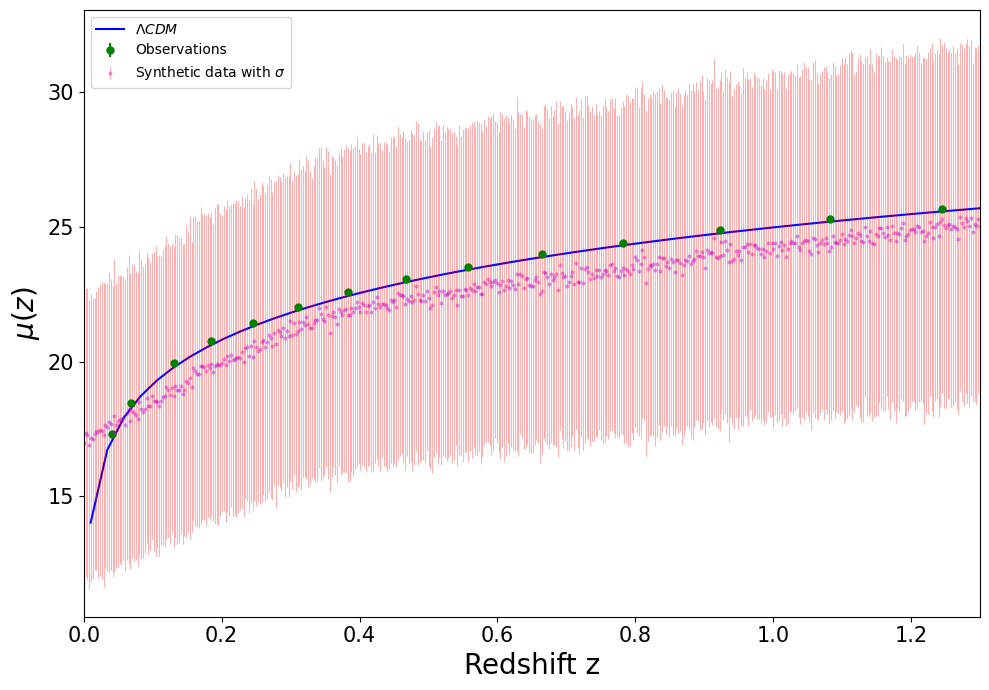

In [23]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(dfp['zCMB'], dfp['MU']-19, dfp['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,1.3)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

# zCMB 	MU 	errors

(0.0, 200.0)

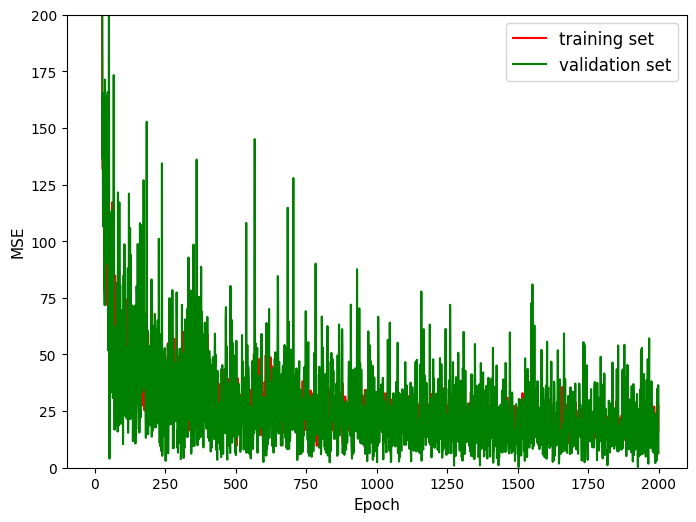

In [24]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 200)
